### useful functions

In [1]:
import scipy.io as scio
import numpy as np
import pywt
from scipy import signal
from matplotlib import pylab
from pylab import *

C:\Users\morta\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def spikedet(signal, threshold):
    detection = []
    for id in range(len(signal)):
        if signal[id] > threshold:
            detection.append(id)
    return detection


def neofilter(v,t):
    neo_value = [0 for _ in range(len(t))]
    peaks = []
    #neo calculation
    for i in range(1,len(t)-1):
        neo_value[i] = v[i]*v[i] - v[i-1]*v[i+1]
    neo_value[0] = neo_value[1]
    neo_value[-1] = neo_value[-2]
    return neo_value

def spikefilter(peaks,strip):
    x = np.array(peaks)
    len_old = x.shape[0]
    for i in range(len_old):
        if i >= x.shape[0] - 1:
            break
        for j in range(strip):#11
            if i >= x.shape[0] - 1:
                break
            if (x[i+1] - x[i]) < strip:#原来10，24k
            #if (x[i+1] - x[i]) < 6: #for DWT
                x = np.delete(x,i+1)
    return x

def dacalculation(groundtruth,detection):
    TP = FP = FN = 0
    misalignment = 0
    i = j = 0
    while((i<len(groundtruth)) & (j < len(detection))):
        if (detection[j] - groundtruth[i] <= 26) & ((detection[j] - groundtruth[i]) >= 0) : #detection succeeds, true positive, pointer both increases
            TP += 1
            misalignment += detection[j] - groundtruth[i]
            i += 1
            j +=1
        elif(detection[j] - groundtruth[i]) > 26: #a spike is missed, false negtive, only ground truth pointer increase
            FN +=1
            i += 1
        else: #noise is detected, false positive, pointer of detection increase
            FP += 1
            j += 1

    FN = FN + (len(groundtruth) - i)
    FP = FP + (len(detection) - j)
    miss = misalignment/TP
    DA = TP/(TP+FN+FP)
    
#     print("TP,FN,FP,DA:")
#     print(TP,FN,FP,DA)
    return DA,miss

def smoothing(datain,t):
    window = signal.windows.boxcar(5)
    smooth = [0 for _ in range(len(t))]
    for i in range(2,len(t)-2):
        smooth[i] = window[0] * datain[i-2] + window[1] * datain[i-1]+ window[2] * datain[i]+ window[3] * datain[i+1]+ window[4] * datain[i+2]
    smooth[0] = window[2] * datain[0] + window[3] * datain[1]+ window[4] * datain[2]
    smooth[1] = window[1] * datain[0] + window[2] * datain[1] + window[3] * datain[2]+ window[4] * datain[3]
    smooth[-1] = window[0] * datain[-3] + window[1] * datain[-2]+ window[2] * datain[-1]
    smooth[-2] = window[0] * datain[-4] + window[1] * datain[-3] + window[2] * datain[-2]+ window[3] * datain[-1]
    
    return np.array(smooth)


In [3]:
def sigma_calculation(v,sigma_a, G, T):
    #values = []
    num = 0
    ratio = 0
    #sigma_a = 0.5 #initial number, not sure the set value
    sigma_t = 0.3173
#     for t,y in v:
#         values.append(y)
#     std = np.std(values)
    for y in v:
        if abs(y) > sigma_a:
            num += 1
    ratio = num/len(v)
    error = ratio - sigma_t
    new_sigma_a = sigma_a + G * T * error
    return new_sigma_a

# Prepare Dataset

In [4]:
names = locals()
stds_ = []
for w in ['005','01','015','02']:
    names['dataFile_e2'+str(w)] = './Simulator/C_Easy2_noise'+ str(w)+'.mat'
    names['dataFile_e1'+str(w)] = './Simulator/C_Easy1_noise'+ str(w)+'.mat'
    names['dataFile_d1'+str(w)] = './Simulator/C_Difficult1_noise'+ str(w)+'.mat'
    names['dataFile_d2'+str(w)] = './Simulator/C_Difficult2_noise'+ str(w)+'.mat'# path is needed to be changed
    names['data_e1'+str(w)],names['data_e2'+str(w)],names['data_d1'+str(w)],names['data_d2'+str(w)] = scio.loadmat(names['dataFile_e1'+str(w)]),scio.loadmat(names['dataFile_e2'+str(w)]),scio.loadmat(names['dataFile_d1'+str(w)]),scio.loadmat(names['dataFile_d2'+str(w)])
    names['spikes_e1'+str(w)],names['spikes_e2'+str(w)],names['spikes_d1'+str(w)],names['spikes_d2'+str(w)] =  names['data_e1'+str(w)]['data'][0], names['data_e2'+str(w)]['data'][0],names['data_d1'+str(w)]['data'][0],names['data_d2'+str(w)]['data'][0]
    stds_.append([np.std(names['spikes_e1'+str(w)]),np.std(names['spikes_e2'+str(w)]),np.std(names['spikes_d1'+str(w)]),np.std(names['spikes_d2'+str(w)])])
    names['index_e1'+str(w)] = names['index_e2'+str(w)] = names['index_d1'+str(w)] = names['index_d2'+str(w)] = np.array(range(len(names['spikes_e2'+str(w)])))
    for i in ['_e1','_e2','_d1','_d2']:
        names['min'+str(i)+str(w)],names['max'+str(i)+str(w)] = names['spikes'+str(i)+str(w)].min(), names['spikes'+str(i)+str(w)].max()
        names['maxvalue'+str(i)+str(w)] = max(abs(names['min'+str(i)+str(w)]),names['max'+str(i)+str(w)])
        names['spikes_nor'+str(i)+str(w)] = (names['spikes'+str(i)+str(w)])/names['maxvalue'+str(i)+str(w)]

In [5]:
for w in ['005','01','015','02']:
    for j in ['e1','e2','d1','d2']:
        #1st wavelet transformation
        (names['cA1_'+str(j)+str(w)], names['cD1_'+str(j)+str(w)]) = pywt.swt(names['spikes_'+str(j)+str(w)],'haar',1)[0]
        #2nd TEO
        #names['teo1_'+str(j)++str(w)] = neofilter(names['cD2_'+str(j)++str(w)], names['index_'+str(j)+str(w)])
        names['teo2_'+str(j)+str(w)] = neofilter(names['cA1_'+str(j)+str(w)], names['index_'+str(j)+str(w)])
        names['spiketeo_'+str(j)+str(w)] = neofilter(names['spikes_'+str(j)+str(w)], names['index_'+str(j)+str(w)])
        if w == '02':
            c = 0.3 #0.4 and 0.5 for 0r gate
        elif w == '0.15':
            c = 0.35
        elif w == '0.1':
            c = 0.4
        else:
            c = 0.45
        #threshold calculation
        names['threshold2_'+str(j)+str(w)] = c*np.std(names['cA1_'+str(j)+str(w)][:10000])
        names['threshold3_'+str(j)+str(w)] = 0.3*np.std(names['spikes_'+str(j)+str(w)][:10000])

        #spike detection
        #names['peaks1_'+str(j)++str(w)] = spikedet(names['smooth1_'+str(j)++str(w)], names['threshold1_'+str(j)++str(w)])
        names['peaks2_'+str(j)+str(w)] = spikedet(names['teo2_'+str(j)+str(w)], names['threshold2_'+str(j)+str(w)])
        names['peaks3_'+str(j)+str(w)] = spikedet(names['spiketeo_'+str(j)+str(w)], names['threshold3_'+str(j)+str(w)])

In [6]:
from functools import reduce
for w in ['005','01','015','02']:
    for i in ['e1','e2','d1','d2']:
        if w == '02':
            s = 11
        else:
            s = 10
        names['peaks_res_'+str(i)+str(w)] = np.intersect1d(names['peaks2_'+str(i)+str(w)], names['peaks3_'+str(i)+str(w)])
        names['detections'+str(i)+str(w)] = spikefilter(names['peaks_res_'+str(i)+str(w)],s)
        #names['detections'+str(i)+str(w)] = names['peaks_res_'+str(i)+str(w)])
        #np.union1d or np.intersect1d

In [7]:
def thresh_calc(sigma):
    return -0.0158 + 0.4043 * sigma

In [8]:
def true_pos(groundtruth,detection,labels):
    TP = FP = FN = 0
    misalignment = 0
    i = j = 0
    detected_indices = []
    gt_indices = []
    gt_labels = []
    while((i<len(groundtruth)) & (j < len(detection))):
        if (detection[j] - groundtruth[i] <= 26) & ((detection[j] - groundtruth[i]) >= 0) : #detection succeeds, true positive, pointer both increases
            TP += 1
            misalignment += detection[j] - groundtruth[i]
            detected_indices.append(j)
            gt_indices.append(i)
            gt_labels.append(labels[i])
            i += 1
            j +=1
            
        elif(detection[j] - groundtruth[i]) > 26: #a spike is missed, false negtive, only ground truth pointer increase
            FN +=1
            i += 1
        else: #noise is detected, false positive, pointer of detection increase
            FP += 1
            j += 1

    return detected_indices,gt_labels

In [9]:
len(detectionse1005)

3484

In [10]:
dacalculation(data_d101['spike_times'][0][0][0],detectionsd101)

(0.9939112786314874, 18.66044340723454)

In [11]:
true_pos(data_e1005['spike_times'][0][0][0],detectionse1005,data_e1005['spike_class'][0][0][0])

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

In [12]:
class Osorter:
    def __init__(self,distance,threshold,update):
        self.distance = distance
        self.threshold= threshold
        self.cluster_means=[]
        self.cluster_cardinality = []
        self.update=update
    
    def closest_cluster(self,signal,test=False):
        min_dist= float("inf")
        for i,center in enumerate(self.cluster_means):
            if(self.cluster_cardinality[i]==-1):
                continue
            if(test and self.cluster_cardinality[i]<np.sum(self.cluster_cardinality)*0.05):
                continue
            dist = self.distance(signal,center)
            if(dist<min_dist):
                min_dist=dist
                ind= i
        if(test):
            try:
                return ind
            except:
                return -1
        if(min_dist<self.threshold):
            return ind
        else:
            return len(self.cluster_means)
        
    def train(self,signal,test=False):
        if(len(self.cluster_means)==0):
            self.cluster_means.append(signal)
            self.cluster_cardinality.append(1)
            return 0
        cluster = self.closest_cluster(signal,test)
        if(cluster==len(self.cluster_means)):
            self.cluster_means.append(signal)
            self.cluster_cardinality.append(1)
            return cluster
        self.cluster_cardinality[cluster]=self.cluster_cardinality[cluster]+1
        self.cluster_means[cluster] =self.update(self.cluster_cardinality[cluster],self.cluster_means[cluster],signal)       
                

        return cluster
    def get_centroids(self):
        return self.cluster_means
        
                
        
        

In [13]:
exact_update = lambda card,mean,signal:  ((card-1) * mean + signal)/card
approx_update = lambda card,mean,signal: mean + (-mean + signal)/2**(np.ceil(max(np.log2(card+1),256)))

In [14]:
from sklearn.metrics import fowlkes_mallows_score
import itertools
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from coclust.evaluation.external import accuracy

C:\Users\morta\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.linear_assignment_ import linear_assignment


def get_tp_class(true_row_labels, predicted_row_labels):
    """Get the best accuracy.

    Parameters
    ----------
    true_row_labels: array-like
        The true row labels, given as external information
    predicted_row_labels: array-like
        The row labels predicted by the model

    Returns
    -------
    float
        Best value of accuracy
    """

    cm = confusion_matrix(true_row_labels, predicted_row_labels)
    indexes = linear_assignment(_make_cost_m(cm))
    total = 0
    for row, column in indexes:
        value = cm[row][column]
        total += value
        

    return total * 1.



def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

In [16]:
get_tp_class([0,0,1,0,1,1,0],[1,1,0,1,0,0,1])

C:\Users\morta\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


7.0

In [17]:
def hypertune(params,datas,gts,update,merging=False):
    keys, values = zip(*params.items())
    permutations_dict = [dict(zip(keys, v)) for v in itertools.product(*values)]
    max_score = 0
    for param in tqdm(permutations_dict):
        score = 0
        for i in range(len(datas)):
            data = datas[i]
            gt= gts[i]
            X_train, X_test, y_train, y_test = train_test_split(data, gt, test_size=0.2,shuffle=True)
            sorter = Osorter(param['distance'],param['thresh'],update)
            c_hat = np.array([sorter.train(x) for x in X_train])
            c_hat = np.array([sorter.train(x,test=True) for x in X_test])
            score += accuracy(y_test,c_hat)
        
        if score>max_score and (-1) not in set(c_hat):
            best_sorter = sorter
            max_score = score
            best_param = param
            best_pred= c_hat
            
    ''' rng = range(len(X_test[0]))
    colors= ['r','b','g','y','w','k','c','m']
    color_dict={}
    i=0
    for v in list(set(best_pred)):
        color_dict[v] = colors[i]
        i+=1
    plt.figure()
    fig,axs = plt.subplots(1,2, figsize=(15, 5))
    for i in range(len(X_test)):
        axs[0].plot(rng,X_test[i],c= color_dict[best_pred[i]],alpha=.1)
        axs[0].set_title('predictions')
    for i in range(len(X_test)):
        axs[1].plot(rng,X_test[i],c='rgbk'[y_test[i]-1],alpha=.1)
        axs[1].set_title('groud truth')
    plt.show()'''
    print(set(best_pred),best_param,max_score/len(datas))
    return best_param,max_score/len(datas)

In [18]:
def l1(x,y):
    return  np.linalg.norm(x-y,ord=1)
def l2(x,y):
    return  np.linalg.norm(x-y,ord=2)**2


In [19]:
noise = [0.05,0.1,0.15,0.2]
thresholds= np.array(noise)*0.2990+0.0191
thresholds

array([0.03405, 0.049  , 0.06395, 0.0789 ])

In [20]:
def train_predict(param,data,gt,update,merging=False):


    X_train, X_test, y_train, y_test = train_test_split(data, gt, test_size=0.2,shuffle=True)
    sorter = Osorter(param['distance'],param['thresh'],update)
    c_hat = np.array([sorter.train(x) for x in X_train])
    c_hat = np.array([sorter.train(x,test=True) for x in X_test])
    score = get_tp_class(y_test,c_hat)
    
    return score

In [21]:
def sign_change_index(lst):
    prev_sign = 0
    for i, num in enumerate(lst):
        sign = 1 if num >= 0 else -1
        if sign != prev_sign and i > 0:
            return i
        prev_sign = sign
    return -1

In [22]:
def thresh_calc(sigma,i,factors):
    return (-1/64 + 13 * sigma/32)*factor(i)
factor = lambda i: 24/int(i)+1 if int(i)!=24 else 1
def feature_extraction(signal,fac):
    fd = np.diff(signal)
    sd = np.diff(fd)
    rankfd = np.argsort(fd)
    ranksd=np.argsort(sd)
    return np.array([factors[0]*min(fd),factors[1]*max(fd),factors[2]*min(sd),factors[3]*max(sd),factors[4]*np.argmax(signal)*3*fac/64]) ##TODO:  Add scaling

In [23]:
import random


In [ ]:

scores = []
data_score = []
noise = ['005','01','015','02']
best_score = 0
k_score = []
df = []
scores_per_combo = []


for a in np.linspace(0.1,5,10):
    for b in np.linspace(0.1,5,10):
        for c in np.linspace(0.1,5,10):
            for d in np.linspace(0.1,5,10):
                for e in np.linspace(0.1,5,10):
                    scores = []
                    for t,i in tqdm(enumerate(noise)):
                        score=[]
                        for j in ['e1','e2','d1','d2']:
                            for trials in range(1):
                                detected_indices,gt = true_pos(names['data_'+j+i]['spike_times'][0][0][0],names['detections'+j+i],names['data_'+j+i]['spike_class'][0][0][0])
                                spike_times = names['detections'+j+i][detected_indices]
                                signal = names['spikes_'+j+i]
                                sigma = np.std(signal)
                                max_ = max(max(signal),abs(min(signal)))

                                signals = list(map(lambda x: signal[x-5:x+20],spike_times))
                                factors= [a,b,c,d,e]
                                features= [feature_extraction(signal,factor('24')) for signal in signals]

                                l1_params ={
                                    'distance':[l2],
                                    'thresh':np.linspace(0.001,10,100),

                                }
                                acc,thresh = hypertune(l1_params,[features],[gt],approx_update,False)
                                print(thresh,acc)
                                score.append([factors,acc])
                        scores.append(score)
                    scores_per_combo.append(scores)



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.9841954022988506
0.9841954022988506 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7104874446085672
0.7104874446085672 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7333333333333333
0.7333333333333333 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6656671664167916
0.6656671664167916 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.9928571428571429
0.9928571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.9728571428571429
0.9728571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7288629737609329
0.7288629737609329 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.42005813953488375
0.42005813953488375 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.9752906976744186
0.9752906976744186 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8862629246676514
0.8862629246676514 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.9363241678726484
0.9363241678726484 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6485294117647059
0.6485294117647059 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.9880418535127056
0.9880418535127056 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.9469914040114613
0.9469914040114613 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.9556868537666174
0.9556868537666174 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6233576642335766
0.6233576642335766 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1, 2, 4, 10, 16} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6551724137931034
0.6551724137931034 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6440177252584933
0.6440177252584933 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 4, 8, 12} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6118518518518519
0.6118518518518519 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5757121439280359
0.5757121439280359 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 4, 15, 28} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6242857142857143
0.6242857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 7, 10} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6142857142857143
0.6142857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5816326530612245
0.5816326530612245 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5363372093023255
0.5363372093023255 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 7, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5770348837209303
0.5770348837209303 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 5, 6, 12, 15} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5494830132939439
0.5494830132939439 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{1, 2, 3, 5, 6, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.46599131693198265
0.46599131693198265 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.45
0.45 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 3, 4, 5, 6, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6457399103139013
0.6457399103139013 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 4, 5, 7, 9, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.498567335243553
0.498567335243553 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 5, 6, 12, 16} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.44903988183161003
0.44903988183161003 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.49635036496350365
0.49635036496350365 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1, 2, 3, 4, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6767241379310345
0.6767241379310345 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 5, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6129985228951256
0.6129985228951256 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 20} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6592592592592592
0.6592592592592592 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5442278860569715
0.5442278860569715 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.67
0.67 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3, 4, 5, 7, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5271428571428571
0.5271428571428571 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 4, 6, 21} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6064139941690962
0.6064139941690962 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5392441860465116
0.5392441860465116 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 5, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5276162790697675
0.5276162790697675 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 4, 5, 6, 7, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5022156573116692
0.5022156573116692 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 4, 6, 8, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5311143270622286
0.5311143270622286 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4985294117647059
0.4985294117647059 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6920777279521674
0.6920777279521674 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6031518624641834
0.6031518624641834 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.4874446085672083
0.4874446085672083 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5080291970802919
0.5080291970802919 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6824712643678161
0.6824712643678161 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6292466765140325
0.6292466765140325 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 2, 3, 4, 5, 10} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6725925925925926
0.6725925925925926 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5142428785607196
0.5142428785607196 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8157142857142857
0.8157142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.66
0.66 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 6, 7, 18} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5276967930029155
0.5276967930029155 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5450581395348837
0.5450581395348837 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.686046511627907
0.686046511627907 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6573116691285081
0.6573116691285081 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.48914616497829233
0.48914616497829233 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 4, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5014705882352941
0.5014705882352941 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6980568011958147
0.6980568011958147 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.6174785100286533
0.6174785100286533 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 2, 3, 4, 5, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.397341211225997
0.397341211225997 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4686131386861314
0.4686131386861314 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1, 2, 3, 4, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6910919540229885
0.6910919540229885 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8552437223042836
0.8552437223042836 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3, 4, 17} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6607407407407407
0.6607407407407407 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 5, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.664167916041979
0.664167916041979 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6957142857142857
0.6957142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.7128571428571429
0.7128571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 2, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6297376093294461
0.6297376093294461 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5334302325581395
0.5334302325581395 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.688953488372093
0.688953488372093 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7459379615952733
0.7459379615952733 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3, 4, 6, 15} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4240231548480463
0.4240231548480463 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5205882352941177
0.5205882352941177 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6860986547085202
0.6860986547085202 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6934097421203438
0.6934097421203438 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.45790251107828656
0.45790251107828656 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5664233576642336
0.5664233576642336 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 3, 4, 5, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6982758620689655
0.6982758620689655 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6809453471196455
0.6809453471196455 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 6, 28} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.677037037037037
0.677037037037037 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5082458770614693
0.5082458770614693 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6985714285714286
0.6985714285714286 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6757142857142857
0.6757142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6107871720116618
0.6107871720116618 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 8} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5363372093023255
0.5363372093023255 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.011} 0.6831395348837209
0.6831395348837209 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.011}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7488921713441654
0.7488921713441654 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5904486251808972
0.5904486251808972 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 7, 14} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4470588235294118
0.4470588235294118 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.695067264573991
0.695067264573991 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6962750716332379
0.6962750716332379 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.4918759231905465
0.4918759231905465 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 3, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.48175182481751827
0.48175182481751827 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6939655172413793
0.6939655172413793 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9793205317577548
0.9793205317577548 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 4, 5, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6711111111111111
0.6711111111111111 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 4, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7076461769115442
0.7076461769115442 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7542857142857143
0.7542857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.78
0.78 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2, 3, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6457725947521866
0.6457725947521866 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5392441860465116
0.5392441860465116 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.8357558139534884
0.8357558139534884 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8493353028064993
0.8493353028064993 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.5455861070911722
0.5455861070911722 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.5823529411764706
0.5823529411764706 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8505231689088192
0.8505231689088192 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.6876790830945558
0.6876790830945558 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.5878877400295421
0.5878877400295421 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.527007299270073
0.527007299270073 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9267241379310345
0.9267241379310345 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8596750369276218
0.8596750369276218 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.6681481481481482
0.6681481481481482 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 2, 5, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6731634182908546
0.6731634182908546 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8314285714285714
0.8314285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7442857142857143
0.7442857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2, 3, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6020408163265306
0.6020408163265306 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6555232558139535
0.6555232558139535 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.747093023255814
0.747093023255814 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7355982274741507
0.7355982274741507 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.6338639652677279
0.6338639652677279 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.5779411764705882
0.5779411764705882 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7683109118086696
0.7683109118086696 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6991404011461319
0.6991404011461319 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5819793205317577
0.5819793205317577 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6248175182481752
0.6248175182481752 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8591954022988506
0.8591954022988506 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8611521418020679
0.8611521418020679 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 5, 8, 12} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.677037037037037
0.677037037037037 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6866566716641679
0.6866566716641679 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7471428571428571
0.7471428571428571 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8785714285714286
0.8785714285714286 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 4, 6, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6166180758017493
0.6166180758017493 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5406976744186046
0.5406976744186046 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.011} 0.6947674418604651
0.6947674418604651 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.011}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7592319054652881
0.7592319054652881 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.613603473227207
0.613603473227207 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5808823529411765
0.5808823529411765 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7832585949177877
0.7832585949177877 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8524355300859598
0.8524355300859598 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6011816838995568
0.6011816838995568 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6204379562043796
0.6204379562043796 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}




{0, 9, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7787356321839081
0.7787356321839081 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.880354505169867
0.880354505169867 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9081481481481481
0.9081481481481481 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 4, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6626686656671664
0.6626686656671664 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8242857142857143
0.8242857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.7714285714285715
0.7714285714285715 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8046647230320699
0.8046647230320699 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6686046511627907
0.6686046511627907 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.7398255813953488
0.7398255813953488 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7754800590841949
0.7754800590841949 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6396526772793053
0.6396526772793053 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.663235294117647
0.663235294117647 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.8893871449925261
0.8893871449925261 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7736389684813754
0.7736389684813754 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6189069423929099
0.6189069423929099 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.5941605839416059
0.5941605839416059 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}




{0, 1, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8850574712643678
0.8850574712643678 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8094534711964549
0.8094534711964549 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.9703703703703703
0.9703703703703703 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.671664167916042
0.671664167916042 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.99
0.99 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.83
0.83 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7186588921282799
0.7186588921282799 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8328488372093024
0.8328488372093024 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 7, 8} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7078488372093024
0.7078488372093024 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7267355982274741
0.7267355982274741 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 7, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.703328509406657
0.703328509406657 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7823529411764706
0.7823529411764706 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8834080717488789
0.8834080717488789 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 5, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6160458452722063
0.6160458452722063 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 4, 5, 17} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6986706056129985
0.6986706056129985 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6510948905109489
0.6510948905109489 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6824712643678161
0.6824712643678161 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6587887740029542
0.6587887740029542 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 2, 3, 5, 6, 7, 8} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6237037037037036
0.6237037037037036 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.697151424287856
0.697151424287856 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 5, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6314285714285715
0.6314285714285715 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 7, 8, 10} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4614285714285714
0.4614285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 10, 11, 23} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5903790087463557
0.5903790087463557 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 6, 7, 8, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5305232558139535
0.5305232558139535 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 7, 16, 22} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4694767441860465
0.4694767441860465 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 6, 9, 10, 12, 13} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.41063515509601184
0.41063515509601184 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 3, 4, 5, 6, 11, 13} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.48914616497829233
0.48914616497829233 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5544117647058824
0.5544117647058824 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 4, 5, 7, 9, 10, 13} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.43946188340807174
0.43946188340807174 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 5, 7, 11, 18} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6246418338108882
0.6246418338108882 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 5, 6, 11, 13} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.47858197932053176
0.47858197932053176 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 7, 8} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.3970802919708029
0.3970802919708029 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 2, 3, 4, 5, 7, 27} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5991379310344828
0.5991379310344828 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5805022156573116
0.5805022156573116 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 4, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.682962962962963
0.682962962962963 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.679160419790105
0.679160419790105 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6414285714285715
0.6414285714285715 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.79
0.79 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 4, 5, 7, 8} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5102040816326531
0.5102040816326531 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5072674418604651
0.5072674418604651 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8313953488372093
0.8313953488372093 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8050221565731167
0.8050221565731167 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2, 3, 4, 6, 9, 13} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5397973950795948
0.5397973950795948 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 4, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5544117647058824
0.5544117647058824 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 7, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6636771300448431
0.6636771300448431 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6461318051575932
0.6461318051575932 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 3, 4, 5, 6, 7, 8, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.43870014771048743
0.43870014771048743 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.45985401459854014
0.45985401459854014 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9841954022988506
0.9841954022988506 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.689807976366322
0.689807976366322 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6518518518518519
0.6518518518518519 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6761619190404797
0.6761619190404797 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6571428571428571
0.6571428571428571 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.95
0.95 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 5, 6, 13, 14} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6545189504373178
0.6545189504373178 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5232558139534884
0.5232558139534884 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.686046511627907
0.686046511627907 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8478581979320532
0.8478581979320532 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 4, 6, 7, 8, 12} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4081041968162084
0.4081041968162084 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5
0.5 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 5, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6935724962630793
0.6935724962630793 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7836676217765043
0.7836676217765043 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3, 4, 5, 7, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4076809453471196
0.4076809453471196 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 5, 10} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.41897810218978104
0.41897810218978104 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 8, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9683908045977011
0.9683908045977011 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.983751846381093
0.983751846381093 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6874074074074074
0.6874074074074074 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 4, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.679160419790105
0.679160419790105 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91} 0.6942857142857143
0.6942857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8657142857142858
0.8657142857142858 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6311953352769679
0.6311953352769679 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 4, 15} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4811046511627907
0.4811046511627907 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7441860465116279
0.7441860465116279 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8168389955686853
0.8168389955686853 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.4905933429811867
0.4905933429811867 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.611764705882353
0.611764705882353 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9192825112107623
0.9192825112107623 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8882521489971347
0.8882521489971347 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5081240768094535
0.5081240768094535 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.45985401459854014
0.45985401459854014 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.6853448275862069
0.6853448275862069 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9601181683899557
0.9601181683899557 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6577777777777778
0.6577777777777778 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 2, 4, 5, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6761619190404797
0.6761619190404797 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8128571428571428
0.8128571428571428 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9142857142857143
0.9142857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3, 4, 5, 15} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6253644314868805
0.6253644314868805 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5552325581395349
0.5552325581395349 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8662790697674418
0.8662790697674418 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9098966026587888
0.9098966026587888 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.5846599131693199
0.5846599131693199 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 3, 5, 8} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5058823529411764
0.5058823529411764 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8490284005979073
0.8490284005979073 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6747851002865329
0.6747851002865329 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.5819793205317577
0.5819793205317577 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.45255474452554745
0.45255474452554745 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.771551724137931
0.771551724137931 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8508124076809453
0.8508124076809453 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2, 3, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.677037037037037
0.677037037037037 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6746626686656672
0.6746626686656672 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.7114285714285714
0.7114285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6828571428571428
0.6828571428571428 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.5845481049562682
0.5845481049562682 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6773255813953488
0.6773255813953488 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7834302325581395
0.7834302325581395 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6942392909896603
0.6942392909896603 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.5557163531114327
0.5557163531114327 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.4808823529411765
0.4808823529411765 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8953662182361734
0.8953662182361734 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6862464183381088
0.6862464183381088 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5317577548005908
0.5317577548005908 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.6467153284671533
0.6467153284671533 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}




{8, 1, 0} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7686781609195402
0.7686781609195402 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9423929098966026
0.9423929098966026 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6844444444444444
0.6844444444444444 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2, 3, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6806596701649176
0.6806596701649176 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.7028571428571428
0.7028571428571428 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8728571428571429
0.8728571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8061224489795918
0.8061224489795918 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 4, 6, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5668604651162791
0.5668604651162791 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.751453488372093
0.751453488372093 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7385524372230429
0.7385524372230429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5586107091172214
0.5586107091172214 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.663235294117647
0.663235294117647 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.828101644245142
0.828101644245142 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7120343839541547
0.7120343839541547 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5435745937961596
0.5435745937961596 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.5635036496350365
0.5635036496350365 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}




{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7830459770114943
0.7830459770114943 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9556868537666174
0.9556868537666174 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.682962962962963
0.682962962962963 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 4, 5, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6401799100449775
0.6401799100449775 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9014285714285715
0.9014285714285715 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8971428571428571
0.8971428571428571 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6268221574344023
0.6268221574344023 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 5, 6, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.565406976744186
0.565406976744186 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.7238372093023255
0.7238372093023255 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7784342688330872
0.7784342688330872 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.6150506512301013
0.6150506512301013 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.675
0.675 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8490284005979073
0.8490284005979073 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7836676217765043
0.7836676217765043 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6587887740029542
0.6587887740029542 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.621897810218978
0.621897810218978 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}




{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7241379310344828
0.7241379310344828 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9586410635155096
0.9586410635155096 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9185185185185185
0.9185185185185185 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6806596701649176
0.6806596701649176 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 2.829} 0.6971428571428572
0.6971428571428572 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 2.829}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7928571428571428
0.7928571428571428 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6895043731778425
0.6895043731778425 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6308139534883721
0.6308139534883721 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7267441860465116
0.7267441860465116 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8330871491875923
0.8330871491875923 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6164978292329957
0.6164978292329957 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6529411764705882
0.6529411764705882 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9043348281016442
0.9043348281016442 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001} 0.6905444126074498
0.6905444126074498 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001}



{0, 9, 2, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6824224519940916
0.6824224519940916 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.6627737226277373
0.6627737226277373 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}




{1, 2, 3, 4, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7830459770114943
0.7830459770114943 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 12} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7104874446085672
0.7104874446085672 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 24} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6414814814814814
0.6414814814814814 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8395802098950524
0.8395802098950524 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7628571428571429
0.7628571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6771428571428572
0.6771428571428572 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2, 3, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6676384839650146
0.6676384839650146 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.561046511627907
0.561046511627907 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6758720930232558
0.6758720930232558 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6691285081240768
0.6691285081240768 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 2, 3, 4, 10} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6367583212735166
0.6367583212735166 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3, 4, 5, 8} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5264705882352941
0.5264705882352941 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6621823617339312
0.6621823617339312 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6805157593123209
0.6805157593123209 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2, 3, 5, 6, 14} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4519940915805022
0.4519940915805022 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{1, 2, 3, 5, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5124087591240876
0.5124087591240876 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6695402298850575
0.6695402298850575 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7296898079763663
0.7296898079763663 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 5, 8, 15} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6577777777777778
0.6577777777777778 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 7, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5232383808095952
0.5232383808095952 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6842857142857143
0.6842857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6842857142857143
0.6842857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3, 4, 6, 7, 8, 10} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5160349854227405
0.5160349854227405 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 3, 4, 6, 7, 8, 16} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.39825581395348836
0.39825581395348836 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7645348837209303
0.7645348837209303 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.691285081240768
0.691285081240768 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3, 4, 5, 9, 11, 12} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4081041968162084
0.4081041968162084 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 4, 6, 10, 11, 12, 14} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.40147058823529413
0.40147058823529413 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 3, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7518684603886397
0.7518684603886397 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6934097421203438
0.6934097421203438 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3, 8, 10, 16, 17} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.40472673559822747
0.40472673559822747 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 3, 4, 11, 13} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.48905109489051096
0.48905109489051096 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9885057471264368
0.9885057471264368 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.982274741506647
0.982274741506647 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{1, 2, 3, 5, 6, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.682962962962963
0.682962962962963 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 6, 13} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6281859070464768
0.6281859070464768 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9928571428571429
0.9928571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9328571428571428
0.9328571428571428 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 4, 5, 7, 14} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.49271137026239065
0.49271137026239065 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5799418604651163
0.5799418604651163 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9811046511627907
0.9811046511627907 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6573116691285081
0.6573116691285081 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 5.758000000000001} 0.38639652677279307
0.38639652677279307 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 5.758000000000001}



{1, 2, 3, 4, 8, 9, 23} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.45441176470588235
0.45441176470588235 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9895366218236173
0.9895366218236173 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8409742120343839
0.8409742120343839 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 3, 6, 8, 11, 14, 16} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.45790251107828656
0.45790251107828656 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 3, 6, 10, 13} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4554744525547445
0.4554744525547445 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9755747126436781
0.9755747126436781 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9852289512555391
0.9852289512555391 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 7, 8, 19} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4962962962962963
0.4962962962962963 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 5, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6131934032983508
0.6131934032983508 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9914285714285714
0.9914285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8657142857142858
0.8657142857142858 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 5, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6399416909620991
0.6399416909620991 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 3, 4, 5, 7, 10, 14} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.561046511627907
0.561046511627907 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9883720930232558
0.9883720930232558 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8906942392909897
0.8906942392909897 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.426917510853835
0.426917510853835 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 4, 5, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.47941176470588237
0.47941176470588237 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9596412556053812
0.9596412556053812 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9426934097421203
0.9426934097421203 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 7, 9, 10, 14, 16} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.44903988183161003
0.44903988183161003 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6087591240875913
0.6087591240875913 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9798850574712644
0.9798850574712644 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9896602658788775
0.9896602658788775 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2, 3, 4, 5, 6, 10} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5733333333333334
0.5733333333333334 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.679160419790105
0.679160419790105 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9942857142857143
0.9942857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9714285714285714
0.9714285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5597667638483965
0.5597667638483965 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5159883720930233
0.5159883720930233 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9854651162790697
0.9854651162790697 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.8124076809453471
0.8124076809453471 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.4934876989869754
0.4934876989869754 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.4676470588235294
0.4676470588235294 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9880418535127056
0.9880418535127056 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8753581661891118
0.8753581661891118 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5420974889217134
0.5420974889217134 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5532846715328467
0.5532846715328467 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9841954022988506
0.9841954022988506 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.982274741506647
0.982274741506647 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.6088888888888889
0.6088888888888889 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 2, 3, 5, 6, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6266866566716641
0.6266866566716641 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.99
0.99 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9714285714285714
0.9714285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6268221574344023
0.6268221574344023 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{3, 4, 6, 7, 8, 10} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5581395348837209
0.5581395348837209 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9825581395348837
0.9825581395348837 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8921713441654358
0.8921713441654358 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5846599131693199
0.5846599131693199 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5573529411764706
0.5573529411764706 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9895366218236173
0.9895366218236173 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9426934097421203
0.9426934097421203 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.49926144756277696
0.49926144756277696 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.602919708029197
0.602919708029197 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.978448275862069
0.978448275862069 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9867060561299852
0.9867060561299852 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7333333333333333
0.7333333333333333 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6506746626686657
0.6506746626686657 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9857142857142858
0.9857142857142858 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9642857142857143
0.9642857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5874635568513119
0.5874635568513119 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6482558139534884
0.6482558139534884 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 2, 4, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9098837209302325
0.9098837209302325 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9172821270310192
0.9172821270310192 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6034732272069464
0.6034732272069464 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.48970588235294116
0.48970588235294116 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9775784753363229
0.9775784753363229 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.8467048710601719
0.8467048710601719 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5657311669128509
0.5657311669128509 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.5518248175182482
0.5518248175182482 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9870689655172413
0.9870689655172413 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9556868537666174
0.9556868537666174 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6711111111111111
0.6711111111111111 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6371814092953523
0.6371814092953523 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9914285714285714
0.9914285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9128571428571428
0.9128571428571428 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6137026239067055
0.6137026239067055 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6540697674418605
0.6540697674418605 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9665697674418605
0.9665697674418605 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9069423929098966
0.9069423929098966 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.5947901591895803
0.5947901591895803 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6470588235294118
0.6470588235294118 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9581464872944694
0.9581464872944694 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.836676217765043
0.836676217765043 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.5361890694239291
0.5361890694239291 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.5620437956204379
0.5620437956204379 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9798850574712644
0.9798850574712644 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9778434268833087
0.9778434268833087 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7822222222222223
0.7822222222222223 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6656671664167916
0.6656671664167916 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9857142857142858
0.9857142857142858 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9671428571428572
0.9671428571428572 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7551020408163265
0.7551020408163265 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.5305232558139535
0.5305232558139535 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.875
0.875 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9010339734121122
0.9010339734121122 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6714905933429812
0.6714905933429812 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6691176470588235
0.6691176470588235 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9835575485799701
0.9835575485799701 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7206303724928367
0.7206303724928367 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6233382570162481
0.6233382570162481 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6467153284671533
0.6467153284671533 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.8390804597701149
0.8390804597701149 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9719350073855244
0.9719350073855244 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.674074074074074
0.674074074074074 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}



{0, 1, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.5862068965517241
0.5862068965517241 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 9, 2, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9328571428571428
0.9328571428571428 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9614285714285714
0.9614285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.739067055393586
0.739067055393586 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6831395348837209
0.6831395348837209 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.8561046511627907
0.8561046511627907 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7296898079763663
0.7296898079763663 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5933429811866859
0.5933429811866859 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5911764705882353
0.5911764705882353 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.874439461883408
0.874439461883408 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.7808022922636103
0.7808022922636103 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6410635155096012
0.6410635155096012 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.5985401459854015
0.5985401459854015 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}




{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.6738505747126436
0.6738505747126436 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1, 3, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.740029542097489
0.740029542097489 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 3, 4, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6325925925925926
0.6325925925925926 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8620689655172413
0.8620689655172413 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.6942857142857143
0.6942857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.6885714285714286
0.6885714285714286 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 2, 3, 4, 5, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.532069970845481
0.532069970845481 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7354651162790697
0.7354651162790697 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.7136627906976745
0.7136627906976745 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6838995568685377
0.6838995568685377 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 4, 5, 8, 10} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.44573082489146165
0.44573082489146165 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5852941176470589
0.5852941176470589 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6576980568011959
0.6576980568011959 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.7034383954154728
0.7034383954154728 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 2, 3, 4, 7, 11, 15} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4815361890694239
0.4815361890694239 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 4, 7, 8} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4364963503649635
0.4364963503649635 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.771551724137931
0.771551724137931 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8700147710487445
0.8700147710487445 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 4, 6, 8, 10, 14, 20} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5155555555555555
0.5155555555555555 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6731634182908546
0.6731634182908546 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7057142857142857
0.7057142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.6885714285714286
0.6885714285714286 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{1, 2, 3, 6, 11, 13, 17, 31} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.41253644314868804
0.41253644314868804 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6613372093023255
0.6613372093023255 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6773255813953488
0.6773255813953488 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{17, 4, 13, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8685376661742984
0.8685376661742984 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 6, 9, 13} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6208393632416788
0.6208393632416788 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.5308823529411765
0.5308823529411765 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2, 4, 5, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7234678624813154
0.7234678624813154 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{8, 1, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7478510028653295
0.7478510028653295 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{10, 19, 12, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7518463810930576
0.7518463810930576 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6583941605839416
0.6583941605839416 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9798850574712644
0.9798850574712644 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9852289512555391
0.9852289512555391 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 4, 6, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5866666666666667
0.5866666666666667 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2, 3, 4, 6, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5667166416791605
0.5667166416791605 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9957142857142857
0.9957142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9628571428571429
0.9628571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{3, 4, 5, 7, 10, 12, 13, 24} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.3892128279883382
0.3892128279883382 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{2, 3, 4, 6, 7, 9, 10, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.44476744186046513
0.44476744186046513 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9811046511627907
0.9811046511627907 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.880354505169867
0.880354505169867 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{3, 4, 12, 14, 17, 18} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4602026049204052
0.4602026049204052 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5676470588235294
0.5676470588235294 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7443946188340808
0.7443946188340808 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7922636103151862
0.7922636103151862 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5790251107828656
0.5790251107828656 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6510948905109489
0.6510948905109489 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9870689655172413
0.9870689655172413 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9940915805022157
0.9940915805022157 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 2, 3, 4, 12, 13} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6562962962962963
0.6562962962962963 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6701649175412294
0.6701649175412294 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9957142857142857
0.9957142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9828571428571429
0.9828571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.5422740524781341
0.5422740524781341 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6627906976744186
0.6627906976744186 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9811046511627907
0.9811046511627907 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9571639586410635
0.9571639586410635 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.61794500723589
0.61794500723589 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6397058823529411
0.6397058823529411 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9880418535127056
0.9880418535127056 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9283667621776505
0.9283667621776505 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.741506646971935
0.741506646971935 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 5, 6, 46} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6072992700729927
0.6072992700729927 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9827586206896551
0.9827586206896551 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9926144756277696
0.9926144756277696 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6503703703703704
0.6503703703703704 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.623688155922039
0.623688155922039 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9914285714285714
0.9914285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.9685714285714285
0.9685714285714285 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6137026239067055
0.6137026239067055 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5770348837209303
0.5770348837209303 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9825581395348837
0.9825581395348837 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9217134416543574
0.9217134416543574 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5918958031837916
0.5918958031837916 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5411764705882353
0.5411764705882353 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9880418535127056
0.9880418535127056 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.8638968481375359
0.8638968481375359 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{3, 4, 9, 14, 27} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5125553914327917
0.5125553914327917 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6321167883211679
0.6321167883211679 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9971264367816092
0.9971264367816092 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9867060561299852
0.9867060561299852 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6474074074074074
0.6474074074074074 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3, 4, 5, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5712143928035982
0.5712143928035982 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9971428571428571
0.9971428571428571 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9785714285714285
0.9785714285714285 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6107871720116618
0.6107871720116618 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6700581395348837
0.6700581395348837 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9869186046511628
0.9869186046511628 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9438700147710487
0.9438700147710487 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.638205499276411
0.638205499276411 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6058823529411764
0.6058823529411764 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9895366218236173
0.9895366218236173 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8896848137535817
0.8896848137535817 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.5952732644017725
0.5952732644017725 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5109489051094891
0.5109489051094891 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9885057471264368
0.9885057471264368 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9867060561299852
0.9867060561299852 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7377777777777778
0.7377777777777778 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5832083958020989
0.5832083958020989 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9928571428571429
0.9928571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.97
0.97 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6574344023323615
0.6574344023323615 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5
0.5 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9840116279069767
0.9840116279069767 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9571639586410635
0.9571639586410635 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6092619392185239
0.6092619392185239 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6558823529411765
0.6558823529411765 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9940209267563528
0.9940209267563528 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8595988538681948
0.8595988538681948 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5494830132939439
0.5494830132939439 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6277372262773723
0.6277372262773723 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9942528735632183
0.9942528735632183 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001} 0.983751846381093
0.983751846381093 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7733333333333333
0.7733333333333333 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 4, 5, 6, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.623688155922039
0.623688155922039 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.99
0.99 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9557142857142857
0.9557142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 9, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7594752186588921
0.7594752186588921 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.5101744186046512
0.5101744186046512 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9811046511627907
0.9811046511627907 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.9379615952732644
0.9379615952732644 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.6078147612156295
0.6078147612156295 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6617647058823529
0.6617647058823529 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9820627802690582
0.9820627802690582 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 2, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.8968481375358166
0.8968481375358166 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6986706056129985
0.6986706056129985 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6291970802919709
0.6291970802919709 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9885057471264368
0.9885057471264368 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9867060561299852
0.9867060561299852 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6725925925925926
0.6725925925925926 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8365817091454273
0.8365817091454273 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9914285714285714
0.9914285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.9742857142857143
0.9742857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6545189504373178
0.6545189504373178 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5959302325581395
0.5959302325581395 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9869186046511628
0.9869186046511628 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9423929098966026
0.9423929098966026 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6107091172214182
0.6107091172214182 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.5838235294117647
0.5838235294117647 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9118086696562033
0.9118086696562033 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.8882521489971347
0.8882521489971347 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.5923190546528804
0.5923190546528804 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5021897810218978
0.5021897810218978 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9899425287356322
0.9899425287356322 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9926144756277696
0.9926144756277696 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.6503703703703704
0.6503703703703704 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7796101949025487
0.7796101949025487 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9885714285714285
0.9885714285714285 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9614285714285714
0.9614285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.6428571428571429
0.6428571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5552325581395349
0.5552325581395349 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9752906976744186
0.9752906976744186 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9527326440177253
0.9527326440177253 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.718} 0.6338639652677279
0.6338639652677279 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.718}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.6794117647058824
0.6794117647058824 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9850523168908819
0.9850523168908819 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.8653295128939829
0.8653295128939829 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 12} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.654357459379616
0.654357459379616 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6321167883211679
0.6321167883211679 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.213} 0.6982758620689655
0.6982758620689655 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.213}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91} 0.6942392909896603
0.6942392909896603 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5718518518518518
0.5718518518518518 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6671664167916042
0.6671664167916042 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.7
0.7 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.6785714285714286
0.6785714285714286 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5233236151603499
0.5233236151603499 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6787790697674418
0.6787790697674418 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6933139534883721
0.6933139534883721 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6957163958641064
0.6957163958641064 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.42257597684515197
0.42257597684515197 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6647058823529411
0.6647058823529411 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.680119581464873
0.680119581464873 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.6805157593123209
0.6805157593123209 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.41802067946824223
0.41802067946824223 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6437956204379562
0.6437956204379562 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.7025862068965517
0.7025862068965517 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6853766617429837
0.6853766617429837 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2, 3, 5, 16} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6103703703703703
0.6103703703703703 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6776611694152923
0.6776611694152923 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.213} 0.7014285714285714
0.7014285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.213}



{0, 4, 5, 11, 15} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.75
0.75 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 4, 7, 9, 20, 26} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6647230320699709
0.6647230320699709 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6758720930232558
0.6758720930232558 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{3, 33, 10, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8212209302325582
0.8212209302325582 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{25, 2, 10} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7548005908419497
0.7548005908419497 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{8, 2, 3, 14} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7756874095513748
0.7756874095513748 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6823529411764706
0.6823529411764706 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 8, 10, 16, 18} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7668161434977578
0.7668161434977578 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.7005730659025788
0.7005730659025788 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{1, 6, 14} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6661742983751846
0.6661742983751846 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.708029197080292
0.708029197080292 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9827586206896551
0.9827586206896551 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9350073855243722
0.9350073855243722 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 3, 6, 7, 15, 16} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6725925925925926
0.6725925925925926 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.656671664167916
0.656671664167916 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9928571428571429
0.9928571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7957142857142857
0.7957142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 4, 6, 8, 9, 11, 13, 28} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.4402332361516035
0.4402332361516035 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6758720930232558
0.6758720930232558 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9767441860465116
0.9767441860465116 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9025110782865583
0.9025110782865583 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6410998552821997
0.6410998552821997 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6455882352941177
0.6455882352941177 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9431988041853513
0.9431988041853513 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7765042979942693
0.7765042979942693 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5066469719350074
0.5066469719350074 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 4, 22, 25} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.5883211678832116
0.5883211678832116 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.985632183908046
0.985632183908046 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9911373707533235
0.9911373707533235 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.64
0.64 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7661169415292354
0.7661169415292354 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9942857142857143
0.9942857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.96
0.96 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6355685131195336
0.6355685131195336 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6744186046511628
0.6744186046511628 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9825581395348837
0.9825581395348837 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8463810930576071
0.8463810930576071 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2, 3, 9, 17} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.723589001447178
0.723589001447178 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6735294117647059
0.6735294117647059 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9880418535127056
0.9880418535127056 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8094555873925502
0.8094555873925502 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 5, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5967503692762186
0.5967503692762186 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.656934306569343
0.656934306569343 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}




{0, 2, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9870689655172413
0.9870689655172413 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.983751846381093
0.983751846381093 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6444444444444445
0.6444444444444445 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 4, 7, 12} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.679160419790105
0.679160419790105 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9957142857142857
0.9957142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9657142857142857
0.9657142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6530612244897959
0.6530612244897959 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7398255813953488
0.7398255813953488 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9854651162790697
0.9854651162790697 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9172821270310192
0.9172821270310192 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 4, 7, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6975397973950795
0.6975397973950795 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6514705882352941
0.6514705882352941 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9895366218236173
0.9895366218236173 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9212034383954155
0.9212034383954155 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5494830132939439
0.5494830132939439 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.654014598540146
0.654014598540146 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}




{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9942528735632183
0.9942528735632183 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.9896602658788775
0.9896602658788775 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}



{0, 3, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6725925925925926
0.6725925925925926 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6686656671664168
0.6686656671664168 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9957142857142857
0.9957142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91} 0.9042857142857142
0.9042857142857142 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6370262390670554
0.6370262390670554 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7398255813953488
0.7398255813953488 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9796511627906976
0.9796511627906976 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9527326440177253
0.9527326440177253 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 3, 4, 15} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6888567293777135
0.6888567293777135 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6779411764705883
0.6779411764705883 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9865470852017937
0.9865470852017937 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8839541547277937
0.8839541547277937 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.740029542097489
0.740029542097489 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6525547445255474
0.6525547445255474 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9913793103448276
0.9913793103448276 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9881831610044313
0.9881831610044313 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6622222222222223
0.6622222222222223 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 4, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7466266866566716
0.7466266866566716 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9942857142857143
0.9942857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9714285714285714
0.9714285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6778425655976676
0.6778425655976676 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7427325581395349
0.7427325581395349 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.9869186046511628
0.9869186046511628 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.011} 0.9320531757754801
0.9320531757754801 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.011}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6801736613603473
0.6801736613603473 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7397058823529412
0.7397058823529412 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9880418535127056
0.9880418535127056 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.011} 0.9326647564469914
0.9326647564469914 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.011}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6646971935007385
0.6646971935007385 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6671532846715329
0.6671532846715329 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9885057471264368
0.9885057471264368 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.9881831610044313
0.9881831610044313 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}



{2, 3, 6, 7, 12} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7007407407407408
0.7007407407407408 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8170914542728636
0.8170914542728636 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9971428571428571
0.9971428571428571 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9828571428571429
0.9828571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 12} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8717201166180758
0.8717201166180758 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7005813953488372
0.7005813953488372 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9869186046511628
0.9869186046511628 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001} 0.9098966026587888
0.9098966026587888 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6555716353111433
0.6555716353111433 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6
0.6 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001} 0.992526158445441
0.992526158445441 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9412607449856734
0.9412607449856734 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6115214180206795
0.6115214180206795 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.618978102189781
0.618978102189781 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}




{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.9841954022988506
0.9841954022988506 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.1119999999999999} 0.9881831610044313
0.9881831610044313 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.1119999999999999}



{0, 1, 10} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.725925925925926
0.725925925925926 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8875562218890555
0.8875562218890555 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.9957142857142857
0.9957142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9742857142857143
0.9742857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7011661807580175
0.7011661807580175 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7093023255813954
0.7093023255813954 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001} 0.9825581395348837
0.9825581395348837 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.9497784342688331
0.9497784342688331 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6092619392185239
0.6092619392185239 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7529411764705882
0.7529411764705882 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.9895366218236173
0.9895366218236173 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.8882521489971347
0.8882521489971347 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.604135893648449
0.604135893648449 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6058394160583942
0.6058394160583942 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.1119999999999999} 0.9885057471264368
0.9885057471264368 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.1119999999999999}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.1119999999999999} 0.983751846381093
0.983751846381093 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.1119999999999999}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.6607407407407407
0.6607407407407407 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5922038980509745
0.5922038980509745 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9971428571428571
0.9971428571428571 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.98
0.98 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7084548104956269
0.7084548104956269 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6831395348837209
0.6831395348837209 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001} 0.9811046511627907
0.9811046511627907 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9571639586410635
0.9571639586410635 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6324167872648335
0.6324167872648335 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.65
0.65 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9880418535127056
0.9880418535127056 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.8782234957020058
0.8782234957020058 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.5760709010339734
0.5760709010339734 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6175182481751825
0.6175182481751825 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}




{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.314} 0.6910919540229885
0.6910919540229885 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.314}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.7163958641063516
0.7163958641063516 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6696296296296296
0.6696296296296296 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6746626686656672
0.6746626686656672 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6985714285714286
0.6985714285714286 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.69
0.69 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6516034985422741
0.6516034985422741 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6642441860465116
0.6642441860465116 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91} 0.6816860465116279
0.6816860465116279 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.314} 0.6824224519940916
0.6824224519940916 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.314}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6454413892908828
0.6454413892908828 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6838235294117647
0.6838235294117647 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.6771300448430493
0.6771300448430493 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.7020057306590258
0.7020057306590258 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6528803545051699
0.6528803545051699 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.67007299270073
0.67007299270073 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}




{0, 1, 3, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7916666666666666
0.7916666666666666 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.415} 0.6957163958641064
0.6957163958641064 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.415}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6503703703703704
0.6503703703703704 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.664167916041979
0.664167916041979 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{4, 7, 8, 10, 15, 16} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7414285714285714
0.7414285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{1, 3, 13, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8628571428571429
0.8628571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{32, 1, 3, 7, 13, 24} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6107871720116618
0.6107871720116618 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6613372093023255
0.6613372093023255 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.6875
0.6875 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.6942392909896603
0.6942392909896603 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.42981186685962375
0.42981186685962375 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6838235294117647
0.6838235294117647 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{4, 12, 14} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7518684603886397
0.7518684603886397 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6948424068767909
0.6948424068767909 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.621861152141802
0.621861152141802 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6715328467153284
0.6715328467153284 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9870689655172413
0.9870689655172413 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9807976366322009
0.9807976366322009 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 4, 5, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8740740740740741
0.8740740740740741 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6821589205397302
0.6821589205397302 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.98
0.98 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7771428571428571
0.7771428571428571 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6661807580174927
0.6661807580174927 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6613372093023255
0.6613372093023255 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91} 0.9622093023255814
0.9622093023255814 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91}



{37, 1, 3, 13} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8404726735598228
0.8404726735598228 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6729377713458755
0.6729377713458755 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6720588235294118
0.6720588235294118 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.976083707025411
0.976083707025411 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7679083094555874
0.7679083094555874 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.55096011816839
0.55096011816839 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6773722627737226
0.6773722627737226 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.985632183908046
0.985632183908046 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9896602658788775
0.9896602658788775 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{3, 12, 13, 15, 18} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7066666666666667
0.7066666666666667 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6626686656671664
0.6626686656671664 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.99
0.99 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9742857142857143
0.9742857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 7, 9, 41, 24} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6749271137026239
0.6749271137026239 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6642441860465116
0.6642441860465116 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.314} 0.9825581395348837
0.9825581395348837 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.314}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8596750369276218
0.8596750369276218 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6078147612156295
0.6078147612156295 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6735294117647059
0.6735294117647059 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9865470852017937
0.9865470852017937 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9126074498567335
0.9126074498567335 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6322008862629247
0.6322008862629247 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6773722627737226
0.6773722627737226 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.985632183908046
0.985632183908046 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91} 0.9867060561299852
0.9867060561299852 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6533333333333333
0.6533333333333333 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6686656671664168
0.6686656671664168 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9928571428571429
0.9928571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9685714285714285
0.9685714285714285 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6661807580174927
0.6661807580174927 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 3, 6, 7, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7122093023255814
0.7122093023255814 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9796511627906976
0.9796511627906976 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9379615952732644
0.9379615952732644 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.76410998552822
0.76410998552822 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6617647058823529
0.6617647058823529 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9805680119581465
0.9805680119581465 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8595988538681948
0.8595988538681948 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6587887740029542
0.6587887740029542 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{1, 2, 3, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6510948905109489
0.6510948905109489 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9885057471264368
0.9885057471264368 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9911373707533235
0.9911373707533235 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6370370370370371
0.6370370370370371 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6701649175412294
0.6701649175412294 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.99
0.99 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.9885714285714285
0.9885714285714285 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6311953352769679
0.6311953352769679 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6671511627906976
0.6671511627906976 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9854651162790697
0.9854651162790697 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.96602658788774
0.96602658788774 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.808972503617945
0.808972503617945 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6676470588235294
0.6676470588235294 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9850523168908819
0.9850523168908819 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9240687679083095
0.9240687679083095 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6129985228951256
0.6129985228951256 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6481751824817519
0.6481751824817519 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}




{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.011} 0.9885057471264368
0.9885057471264368 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.011}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.415} 0.9926144756277696
0.9926144756277696 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.415}



{0, 9, 10, 11, 15, 19} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6622222222222223
0.6622222222222223 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.863568215892054
0.863568215892054 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.99
0.99 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.415} 0.9771428571428571
0.9771428571428571 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.415}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6574344023323615
0.6574344023323615 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7630813953488372
0.7630813953488372 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9898255813953488
0.9898255813953488 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9630723781388478
0.9630723781388478 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6642547033285094
0.6642547033285094 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6779411764705883
0.6779411764705883 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.9865470852017937
0.9865470852017937 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9326647564469914
0.9326647564469914 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6558345642540621
0.6558345642540621 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001} 0.6759124087591241
0.6759124087591241 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001} 0.9885057471264368
0.9885057471264368 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.983751846381093
0.983751846381093 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8
0.8 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9460269865067467
0.9460269865067467 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9957142857142857
0.9957142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001} 0.9828571428571429
0.9828571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001}



{2, 3, 8, 9, 27} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.706997084548105
0.706997084548105 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8197674418604651
0.8197674418604651 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9912790697674418
0.9912790697674418 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.9556868537666174
0.9556868537666174 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8060781476121563
0.8060781476121563 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.6367647058823529
0.6367647058823529 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001} 0.9910313901345291
0.9910313901345291 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.9297994269340975
0.9297994269340975 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}



{0, 2, 4, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6838995568685377
0.6838995568685377 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6832116788321168
0.6832116788321168 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.9913793103448276
0.9913793103448276 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9881831610044313
0.9881831610044313 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6696296296296296
0.6696296296296296 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8875562218890555
0.8875562218890555 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9914285714285714
0.9914285714285714 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9757142857142858
0.9757142857142858 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 4, 9, 15, 20} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.641399416909621
0.641399416909621 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.684593023255814
0.684593023255814 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9854651162790697
0.9854651162790697 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9601181683899557
0.9601181683899557 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.6613603473227206
0.6613603473227206 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.65
0.65 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.9895366218236173
0.9895366218236173 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.9011461318051576
0.9011461318051576 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.6056129985228951
0.6056129985228951 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6423357664233577
0.6423357664233577 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.9913793103448276
0.9913793103448276 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.1119999999999999} 0.983751846381093
0.983751846381093 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.1119999999999999}



{0, 1, 2, 9} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6681481481481482
0.6681481481481482 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8215892053973014
0.8215892053973014 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.9942857142857143
0.9942857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91} 0.9828571428571429
0.9828571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6895043731778425
0.6895043731778425 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7572674418604651
0.7572674418604651 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91} 0.9869186046511628
0.9869186046511628 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.718} 0.9645494830132939
0.9645494830132939 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.718}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001} 0.6266280752532561
0.6266280752532561 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001}



{0, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.6470588235294118
0.6470588235294118 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506} 0.992526158445441
0.992526158445441 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.506}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001} 0.9255014326647565
0.9255014326647565 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.7080000000000001}



{0, 1, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.689807976366322
0.689807976366322 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91} 0.5795620437956205
0.5795620437956205 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.91}




{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.7011494252873564
0.7011494252873564 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.6957163958641064
0.6957163958641064 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6711111111111111
0.6711111111111111 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6581709145427287
0.6581709145427287 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6942857142857143
0.6942857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 2.4250000000000003} 0.7228571428571429
0.7228571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 2.4250000000000003}



{0, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6501457725947521
0.6501457725947521 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.6816860465116279
0.6816860465116279 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6991279069767442
0.6991279069767442 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.689807976366322
0.689807976366322 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.5687409551374819
0.5687409551374819 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6764705882352942
0.6764705882352942 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7488789237668162
0.7488789237668162 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 2.324} 0.7048710601719198
0.7048710601719198 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 2.324}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6676514032496307
0.6676514032496307 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.656934306569343
0.656934306569343 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005} 0.6939655172413793
0.6939655172413793 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.30400000000000005}



{2, 3, 8, 9, 16} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.725258493353028
0.725258493353028 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6577777777777778
0.6577777777777778 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6806596701649176
0.6806596701649176 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809} 0.7242857142857143
0.7242857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.809}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 2.021} 0.6957142857142857
0.6957142857142857 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 2.021}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6938775510204082
0.6938775510204082 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6656976744186046
0.6656976744186046 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{9, 2, 12} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7877906976744186
0.7877906976744186 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.314} 0.7031019202363368
0.7031019202363368 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.314}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6801736613603473
0.6801736613603473 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6602941176470588
0.6602941176470588 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.1119999999999999} 0.6786248131539612
0.6786248131539612 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.1119999999999999}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.516} 0.7077363896848138
0.7077363896848138 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 1.516}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6262924667651403
0.6262924667651403 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405} 0.6686131386861314
0.6686131386861314 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.405}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9267241379310345
0.9267241379310345 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.827178729689808
0.827178729689808 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{16, 9, 3, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.7762962962962963
0.7762962962962963 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6836581709145427
0.6836581709145427 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9871428571428571
0.9871428571428571 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.93
0.93 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 8, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.6384839650145773
0.6384839650145773 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6758720930232558
0.6758720930232558 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 6} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9462209302325582
0.9462209302325582 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9276218611521418
0.9276218611521418 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.638205499276411
0.638205499276411 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6808823529411765
0.6808823529411765 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2, 8} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8654708520179372
0.8654708520179372 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.8209169054441261
0.8209169054441261 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 7} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6573116691285081
0.6573116691285081 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6627737226277373
0.6627737226277373 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}




{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9885057471264368
0.9885057471264368 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9704579025110783
0.9704579025110783 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7348148148148148
0.7348148148148148 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6761619190404797
0.6761619190404797 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9928571428571429
0.9928571428571429 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 2, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8642857142857143
0.8642857142857143 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{9, 18, 11} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001} 0.8877551020408163
0.8877551020408163 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.001}



{0, 1, 4} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.7107558139534884
0.7107558139534884 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9854651162790697
0.9854651162790697 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9409158050221565
0.9409158050221565 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6613603473227206
0.6613603473227206 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6897058823529412
0.6897058823529412 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.9671150971599403
0.9671150971599403 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1, 2} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.8753581661891118
0.8753581661891118 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1, 3, 5} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6100443131462334
0.6100443131462334 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.6598540145985401
0.6598540145985401 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}




{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001} 0.9899425287356322
0.9899425287356322 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.6070000000000001}



{0, 1, 3} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001} 0.9970457902511078
0.9970457902511078 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.10200000000000001}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.6518518518518519
0.6518518518518519 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}



{0, 1} {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203} 0.7016491754122939
0.7016491754122939 {'distance': <function l2 at 0x0000022ED6837310>, 'thresh': 0.203}


In [48]:
np.mean(scores)

0.9372227913004562

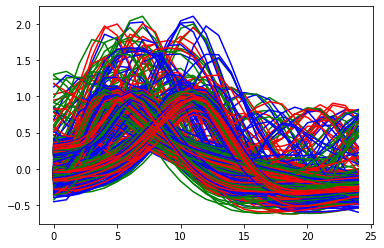

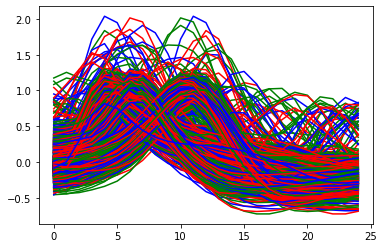

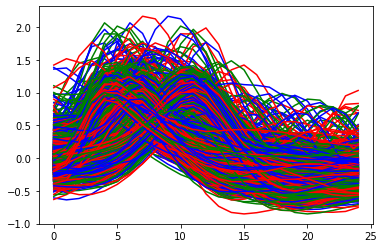

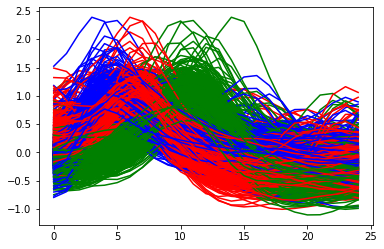

In [44]:
for t,i in tqdm(enumerate(noise)):
    data_score= []
    for j in ['d2']:
        scores=[]
        spike_times = names['data_'+j+i]['spike_times'][0][0][0]
        signal = names['spikes_'+j+i]
        sigma = np.std(signal)
        max_ = max(max(signal),abs(min(signal)))

        signals = list(map(lambda x: signal[x+15:x+40],spike_times))
        for i,sig in enumerate(signals):
            plt.plot(range(len(sig)),sig,c='rgbk'[gt[i]-1])
        plt.show()

In [67]:
import pandas as pd
data = pd.DataFrame(df,columns=['sigma','thresh','max','min','score'])
data

,sigma,thresh,max,min,score
0,0.150903,0.277083,2.007850,-1.912727,0.967311
1,0.130158,0.100000,2.011434,-0.867418,0.912789
2,0.120645,0.100000,2.081193,-1.233299,0.691129
3,0.120949,0.100000,2.106147,-0.622426,0.647198
4,0.175109,0.266667,2.003679,-1.893337,0.975347
5,0.157503,0.100000,2.123953,-0.939364,0.850327
6,0.148559,0.100000,2.073344,-1.306022,0.910409
7,0.149752,0.100000,2.037536,-0.725867,0.344688
8,0.206212,0.329167,1.860984,-2.005612,0.951330
9,0.192163,0.120833,2.359126,-1.077659,0.684442


In [35]:
data = data[data['score']<0.9]

In [29]:
data[data['score']>0.9].mean()

sigma     0.175572
thresh    0.075169
max       2.130491
min      -1.373390
score     0.978250
dtype: float64

In [43]:
np.mean(np.mean(np.array(k_score),axis=-1),axis=-1)

array([[nan, nan, nan, nan]])

In [181]:
np.mean(means[:,0,:-1])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

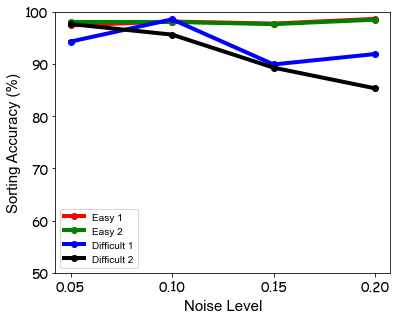

In [183]:
plt.figure(figsize=(6,4.8))
noise = [0.05,0.1,0.15,0.2]
titles = ['Easy 1','Easy 2', 'Difficult 1','Difficult 2']

for i in range(len(means)):
    plt.plot(noise,means[i]*100,color = 'rgbk'[i],marker='o',markersize=6,linewidth = '4',label=titles[i])
plt.ylim(50,100)
plt.xticks(noise,size=14)
plt.yticks(size = 14)
plt.xlabel('Noise Level',fontsize=15,fontname="Arial")
plt.ylabel('Sorting Accuracy (%)',fontsize=15,fontname="Arial")
plt.legend(loc='lower left',prop={'family': 'Arial'})
plt.savefig('NoiseVSAccuracy.png',dpi=400, transparent=True,bbox_inches = 'tight')


In [57]:
means

array([[0.97345661, 0.98292199, 0.96875   , 0.96559712],
       [0.98316716, 0.98318182, 0.98519766, 0.98376771],
       [0.9774003 , 0.96508696, 0.93027338, 0.94169839],
       [0.9840416 , 0.96731602, 0.92005814, 0.91329041]])

In [59]:
mean_exact = np.mean(means,axis=0)

In [60]:
mean_approx = np.mean(means_,axis=0)

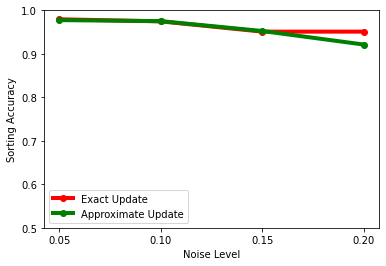

In [65]:
plt.figure()
ln2, = plt.plot(noise, mean_exact,color = 'red',marker = 'o' ,markersize = 6,linewidth = 4)
ln3, = plt.plot(noise, mean_approx,color = 'green',marker = 'o', markersize = 6,linewidth = 4)
plt.legend(handles=[ln2, ln3], labels=['Exact Update','Approximate Update'],loc='lower left')
plt.ylim(0.5,1)
plt.xticks(noise)
plt.xlabel('Noise Level')
plt.ylabel('Sorting Accuracy')
#plt.title("DA vs RS of different methods when noise level = 0.1")
plt.show()

In [41]:
def hypertune(params,datas,gts,update,merging=False):
    keys, values = zip(*params.items())
    permutations_dict = [dict(zip(keys, v)) for v in itertools.product(*values)]
    max_score = 0
    for param in permutations_dict:
        score = 0
        for i in range(len(datas)):
            
            data = datas[i]
            gt= gts[i]
            X_train, X_test, y_train, y_test = train_test_split(data, gt, test_size=0.2,shuffle=True)
            sorter = Osorter(param['distance'],param['thresh'],update)
            c_hat = [sorter.train(x) for x in X_train]
            c_hat = np.array([sorter.train(x,test=True) for x in X_test])
            score += accuracy(y_test,c_hat)
        
        if score>max_score and (-1) not in set(c_hat):
            best_sorter = sorter
            max_score = score
            best_param = param
    
    return max_score/len(datas),best_param['thresh']

In [42]:
def fsde(signal,fac):
    fd = np.diff(signal)
    sd = np.diff(fd)
    rankfd = np.argsort(fd)
    ranksd=np.argsort(sd)
    return np.array([min(fd),max(fd),min(sd),max(sd)])

In [43]:

scores = []
data_score = []
noise = ['005','01','015','02']
noise_score= []
df = []
for t,i in tqdm(enumerate(noise)):

    data_score= []
    for j in ['e1','e2','d1','d2']:
        scores=[]
        spike_times = names['data_'+j+i]['spike_times'][0][0][0]
        signal = names['spikes_'+j+i]
        sigma = np.std(signal)

        gt= names['data_'+j+i]['spike_class'][0][0][0]

        signals = list(map(lambda x: signal[x+15:x+40],spike_times))
        features= [fsde(signal,factor('24')) for signal in signals]
        l1_params ={
            'distance':[l2],
            'thresh':[0.2065*sigma]

        }

        for loop in tqdm(range(5)):
            l1_score,thresh = hypertune(l1_params,[features],[gt],approx_update,False)
            print(l1_score)
            scores.append(l1_score)
            df.append([thresh,sigma])

        data_score.append(scores)
    noise_score.append(data_score)

0.9743954480796586
0.9800853485064012
0.9815078236130867
0.9857752489331437
0.9772403982930299



0.6686217008797654
0.6627565982404692
0.6686217008797654
0.6700879765395894
0.6598240469208211



0.9852289512555391
0.9748892171344166
0.9807976366322009
0.9807976366322009
0.982274741506647



0.6790490341753344
0.6775631500742942
0.6567607726597325
0.6686478454680534
0.6671619613670133



0.9843971631205674
0.9843971631205674
0.9815602836879432
0.9886524822695035
0.9900709219858156



0.6164772727272727
0.6732954545454546
0.7088068181818182
0.6647727272727273
0.6775568181818182



0.8347826086956521
0.9826086956521739
0.9797101449275363
0.7565217391304347
0.8420289855072464



0.6536796536796536
0.6594516594516594
0.6724386724386724
0.6753246753246753
0.6666666666666666



0.9727011494252874
0.978448275862069
0.9770114942528736
0.9022988505747126
0.9813218390804598



0.6500732064421669
0.657393850658858
0.677891654465593
0.6661786237188873
0.6632503660322109



0.9827338129496402
0.8848920863309353
0.9741007194244604
0.8906474820143885
0.9654676258992806



0.6918604651162791
0.6656976744186046
0.6482558139534884
0.6598837209302325
0.8444767441860465



0.981294964028777
0.8345323741007195
0.9697841726618706
0.9640287769784173
0.8287769784172662



0.6827195467422096
0.7110481586402266
0.6713881019830028
0.6685552407932012
0.6685552407932012



0.8609077598828697
0.7510980966325037
0.849194729136164
0.8330893118594437
0.9472913616398243



0.6552217453505007
0.6723891273247496
0.7753934191702432
0.5736766809728183
0.6623748211731044




In [29]:
import pandas as pd
data = pd.DataFrame(df,columns=['thresh','sigma'])

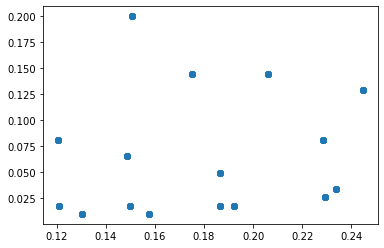

In [30]:
plt.scatter(data.sigma,data.thresh)

In [31]:
import statsmodels.api as sm
Y = data.thresh
X = data.sigma
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 thresh   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.632
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.205
Time:                        13:47:43   Log-Likelihood:                 115.60
No. Observations:                  80   AIC:                            -227.2
Df Residuals:                      78   BIC:                            -222.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0285      0.030      0.962      0.339      -0.030       0.087
sigma          0.2065      0.162      1.278      0.205      -0.115       0.528
==============================================================================
Omnibus:                       12.070   Durbin-Watson:                   0.516
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.798
Skew:                           1.017   Prob(JB):                      0.00101
Kurtosis:                       2.966   Cond. No.                         25.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""